<img src="http://www.cems.uwe.ac.uk/~pa-legg/images/uwe_banner.png">

# UFCFEL-15-3 Security Data Analytics and Visualisation
# Portfolio Assignment 3: Large-Scale Data Exploration for Insider Threat Detection  (2022)
---

The completion of this worksheet is worth a **maximum of 45 marks** towards your portfolio assignment for the UFCFEL-15-3 Security Data Analytics and Visualisation (SDAV) module.

### Brief
---

In this task, you have been asked to investigate a potential security threat within an organisation. Building on your previous worksheet expertise, you will need to apply your skills and knowledge of data analytics and visualisation to examine and explore the datasets methodically to uncover which employee is acting as a threat and why. The company have provided you with activity logs for various user interactions for the past 6 months, resulting in a lot of data that they need your expertise for to decipher. They want to have a report that details the investigation that you have carried out, details of the suspected individual, and a clear rationale as to why this suspect is flagged. You will need to document your investigation, giving clear justification for your process using Markdown annotation within your notebook. You will need to provide a clear rationale for why you suspect a given individual to be acting as a threat, based on the pattern of activity that you identify.

<i>This coursework is specifically designed to challenge your critical thinking and creativity, and is designed as an open problem. Examine the data and try to think how an individual user may appear as an anomaly against the remainder of the data. This could be an anomaly compared to a group of users, or an anomaly as compared over time.</i>

### Assessment and Marking
---

Marks will be allocated within the following criteria:

* **Identification and justification of the suspicious behaviour (15)**
* **Analytical process and reasoning to deduce the suspicious behaviour (15)**
* **Use of informative visualisation and data exploration techniques (10)**
* **Clarity and professional presentation (5)**

To achieve the higher end of the grade scale, you need to demonstrate creativity in how you approach the problem of identifying malicious behaviours, and ensure that you have accounted for multiple anomalies across the set of data available.

This assignment should be submitted as as PDF to your Blackboard portfolio submission as per the instructions in the assignment specification available on Blackboard. A copy of your work should also be provided via a UWE Gitlab repository, with an accessible link provided with your portfolio.

### Contact
---

Questions about this assignment should be directed to your module leader (Phil.Legg@uwe.ac.uk). You can use the Blackboard Q&A feature to ask questions related to this module and this assignment, as well as the on-site teaching sessions.

---


## Load in the data

In [5]:
# DO NOT MODIFY THIS CELL - this cell is splitting the data to provide a suitable subset of data to work with for this task.
# If you change this cell your output will differ from that expected and could impact your mark.

import random
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import datetime
import networkx as nx
from matplotlib.pyplot import figure
import numpy as np

dataset_list = ['onlinebargains']
DATASET = dataset_list[0]

def load_data(DATASET):
    if DATASET in dataset_list:
        email_data = pd.read_csv('DATA/T3_data/' + DATASET + '/email_data.csv', parse_dates=True, index_col=0)
        file_data = pd.read_csv('DATA/T3_data/' + DATASET + '/file_data.csv', parse_dates=True, index_col=0)
        web_data = pd.read_csv('DATA/T3_data/' + DATASET + '/web_data.csv', parse_dates=True, index_col=0)
        login_data = pd.read_csv('DATA/T3_data/' + DATASET + '/login_data.csv', parse_dates=True, index_col=0)
        usb_data = pd.read_csv('DATA/T3_data/' + DATASET + '/usb_data.csv', parse_dates=True, index_col=0)
        employee_data = pd.read_csv('DATA/T3_data/' + DATASET + '/employee_data.csv', index_col=0)
        
        email_data['datetime'] = pd.to_datetime(email_data['datetime'])
        file_data['datetime'] = pd.to_datetime(file_data['datetime'])
        web_data['datetime'] = pd.to_datetime(web_data['datetime'])
        login_data['datetime'] = pd.to_datetime(login_data['datetime'])
        usb_data['datetime'] = pd.to_datetime(usb_data['datetime'])
    else:
        print ("DATASET variable not defined")
        return
    return employee_data, login_data, usb_data, web_data, file_data, email_data

employee_data, login_data, usb_data, web_data, file_data, email_data = load_data(DATASET)
employee_data

,user,role,email,pc
0,usr-uda,Security,usr-uda@onlinebargains.com,pc0
1,usr-hhe,Security,usr-hhe@onlinebargains.com,pc1
2,usr-vxr,Finance,usr-vxr@onlinebargains.com,pc2
3,usr-nba,Finance,usr-nba@onlinebargains.com,pc3
4,usr-hqt,Finance,usr-hqt@onlinebargains.com,pc4
...,...,...,...,...
244,usr-jwo,Finance,usr-jwo@onlinebargains.com,pc244
245,usr-hiz,Security,usr-hiz@onlinebargains.com,pc245
246,usr-svz,Services,usr-svz@onlinebargains.com,pc246
247,usr-ndr,HR,usr-ndr@onlinebargains.com,pc247


The cell above is creating a set of DataFrames to work with. The set of tables are named as follows:

* employee_data
* login_data
* usb_data
* web_data
* file_data
* email_data



# 1. Begin investigation

To start I will investigate...

In [6]:
employee_data

,user,role,email,pc
0,usr-uda,Security,usr-uda@onlinebargains.com,pc0
1,usr-hhe,Security,usr-hhe@onlinebargains.com,pc1
2,usr-vxr,Finance,usr-vxr@onlinebargains.com,pc2
3,usr-nba,Finance,usr-nba@onlinebargains.com,pc3
4,usr-hqt,Finance,usr-hqt@onlinebargains.com,pc4
...,...,...,...,...
244,usr-jwo,Finance,usr-jwo@onlinebargains.com,pc244
245,usr-hiz,Security,usr-hiz@onlinebargains.com,pc245
246,usr-svz,Services,usr-svz@onlinebargains.com,pc246
247,usr-ndr,HR,usr-ndr@onlinebargains.com,pc247


In [3]:
employee_data['role'].value_counts()

Services     49
HR           44
Legal        37
Security     33
Technical    32
Finance      30
Director     24
Name: role, dtype: int64

In [9]:
login= pd.DataFrame(login_data)
login['hours'] = login['datetime'].dt.hour
login

,datetime,user,action,pc,hours
0,2020-01-01 00:21:33,usr-hyo,login,pc205,0
1,2020-01-01 00:21:39,usr-ipd,login,pc230,0
2,2020-01-01 00:34:25,usr-nrx,login,pc169,0
3,2020-01-01 00:35:10,usr-hfz,login,pc111,0
4,2020-01-01 00:39:04,usr-hhe,login,pc1,0
...,...,...,...,...,...
166825,2020-11-30 23:42:54,usr-ays,logoff,pc167,23
166826,2020-11-30 23:44:18,usr-alj,logoff,pc168,23
166827,2020-11-30 23:51:29,usr-nic,logoff,pc180,23
166828,2020-11-30 23:56:34,usr-vul,logoff,pc54,23


In [117]:
#grouping the hours during a day
def split_day(df,cut_points,label_names):
    df["hours"] = df["hours"].fillna(-0.5)
    df["hour_categories"] = pd.cut(df["hours"],cut_points,labels=label_names)
    return df

cut_points = [-1,0,12,18,24]
label_names = ["midnight","morning","afternoon","evening"]

login = split_day(login,cut_points,label_names)
usb_data = split_day(usb_data,cut_points,label_names)
web_data = split_day(web_data,cut_points,label_names)
file_data = split_day(file_data,cut_points,label_names)
email_data = split_day(email_data,cut_points,label_names)

login

,datetime,user,action,pc,hours,hour_categories
0,2020-01-01 00:21:33,usr-hyo,login,pc205,0,midnight
1,2020-01-01 00:21:39,usr-ipd,login,pc230,0,midnight
2,2020-01-01 00:34:25,usr-nrx,login,pc169,0,midnight
3,2020-01-01 00:35:10,usr-hfz,login,pc111,0,midnight
4,2020-01-01 00:39:04,usr-hhe,login,pc1,0,midnight
...,...,...,...,...,...,...
166825,2020-11-30 23:42:54,usr-ays,logoff,pc167,23,evening
166826,2020-11-30 23:44:18,usr-alj,logoff,pc168,23,evening
166827,2020-11-30 23:51:29,usr-nic,logoff,pc180,23,evening
166828,2020-11-30 23:56:34,usr-vul,logoff,pc54,23,evening


In [245]:
dfLE = pd.merge(login,employee_data)
dfLE

,datetime,user,action,pc,hours,hour_categories,role,email
0,2020-01-01 00:21:33,usr-hyo,login,pc205,0,midnight,Director,usr-hyo@onlinebargains.com
1,2020-01-01 22:56:43,usr-hyo,logoff,pc205,22,evening,Director,usr-hyo@onlinebargains.com
2,2020-01-02 09:48:15,usr-hyo,login,pc205,9,morning,Director,usr-hyo@onlinebargains.com
3,2020-01-02 23:08:08,usr-hyo,logoff,pc205,23,evening,Director,usr-hyo@onlinebargains.com
4,2020-01-03 05:14:25,usr-hyo,login,pc205,5,morning,Director,usr-hyo@onlinebargains.com
...,...,...,...,...,...,...,...,...
166825,2020-11-28 22:33:12,usr-zwq,logoff,pc151,22,evening,Director,usr-zwq@onlinebargains.com
166826,2020-11-29 02:46:56,usr-zwq,login,pc151,2,morning,Director,usr-zwq@onlinebargains.com
166827,2020-11-29 21:29:16,usr-zwq,logoff,pc151,21,evening,Director,usr-zwq@onlinebargains.com
166828,2020-11-30 04:41:00,usr-zwq,login,pc151,4,morning,Director,usr-zwq@onlinebargains.com


In [88]:
logoff_time = login[login['action']=='logoff']
login_time = login[login['action']=='login']

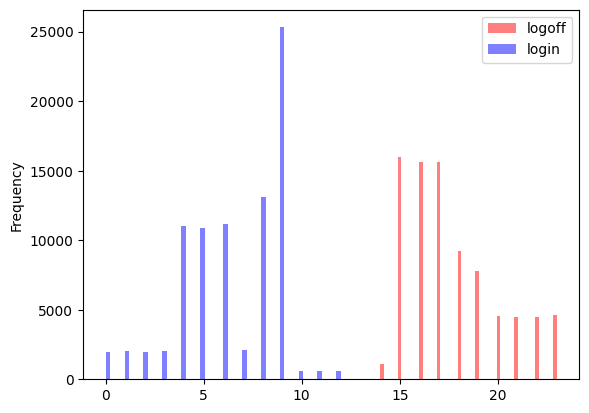

In [89]:
#to being able to make assumptions about the shifts hourly.
logoff_time['hours'].plot.hist(alpha=0.5,color='red', bins=50)
login_time['hours'].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['logoff','login'])
plt.show()

<AxesSubplot:ylabel='Frequency'>

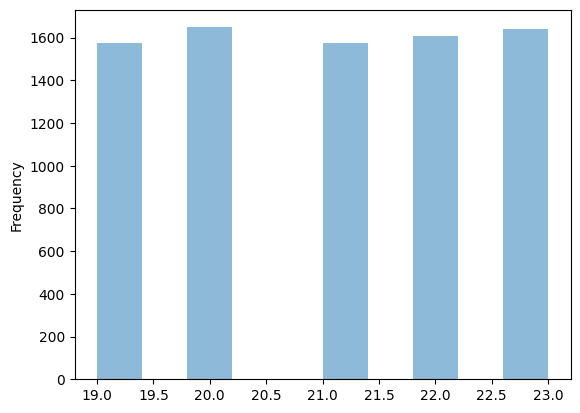

In [257]:
ddfLE=dfLE[(dfLE['role']=='Director')&(dfLE['action']=='logoff')]
ddfLE['hours'].plot.hist(alpha=0.5)

In [246]:
loginRHD = login.loc[(login['user']=='usr-rhd')&(login['action']=='login')]
logoffRHD = login.loc[(login['user']=='usr-rhd')&(login['action']=='logoff')]

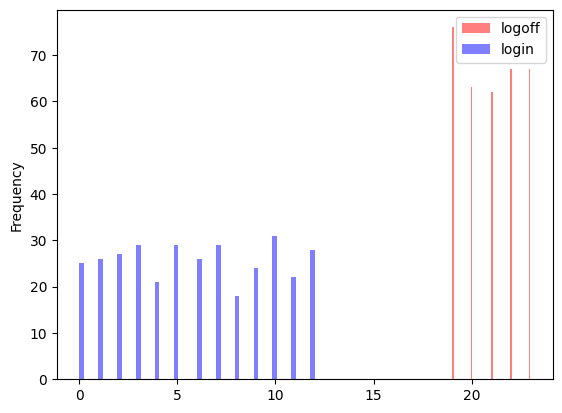

In [247]:
#login and logoff hours of the suspect
logoffRHD['hours'].plot.hist(alpha=0.5,color='red', bins=50)
loginRHD['hours'].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['logoff','login'])
plt.show()

In [118]:
usb= pd.DataFrame(usb_data)
usb['hours'] = usb['datetime'].dt.hour
usb

,datetime,user,action,pc,hours,hour_categories
0,2020-01-01 04:34:12.544490,usr-mcr,usb_insert,pc13,4,morning
1,2020-01-01 04:38:24.821774,usr-udb,usb_insert,pc66,4,morning
2,2020-01-01 04:40:59.860587,usr-con,usb_insert,pc146,4,morning
3,2020-01-01 04:45:49.701116,usr-xsn,usb_insert,pc30,4,morning
4,2020-01-01 04:49:10.958272,usr-rjw,usb_insert,pc226,4,morning
...,...,...,...,...,...,...
460707,2020-11-30 21:52:23.963103,usr-ebj,usb_insert,pc107,21,evening
460708,2020-11-30 21:59:12.697110,usr-ebj,usb_remove,pc107,21,evening
460709,2020-11-30 22:05:32.796175,usr-fbi,usb_remove,pc177,22,evening
460710,2020-11-30 22:28:48.961482,usr-fbi,usb_insert,pc177,22,evening


In [33]:
insert_table = usb[usb['action']=='usb_insert']
remove_table = usb[usb['action']=='usb_remove']

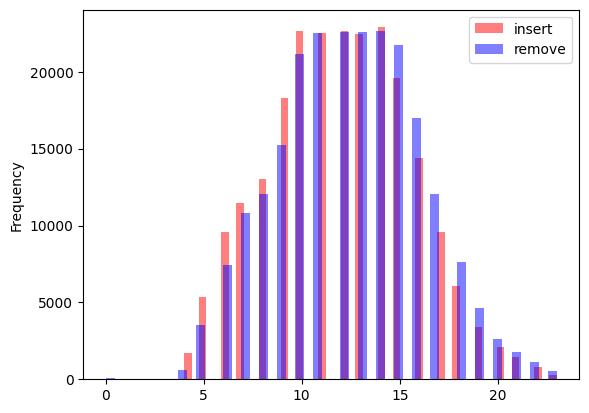

In [259]:
#when an insert or remove appeared in the df
insert_table['hours'].plot.hist(alpha=0.5,color='red', bins=50)
remove_table['hours'].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['insert','remove'])
plt.show()

In [260]:
#inspecting the usb data at suspecious hours. 
usbSUS = usb.loc[(usb['hours']>=20)&(usb['hours']<=23)]

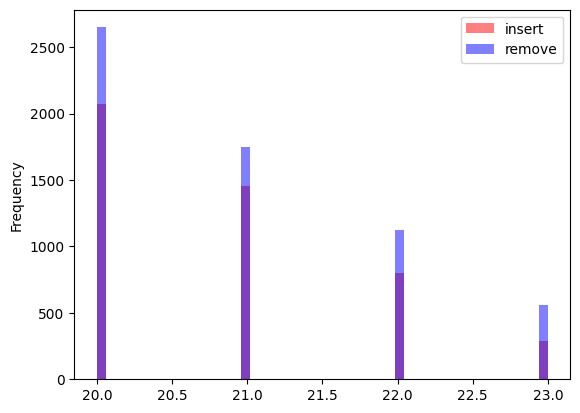

In [36]:
insertSUS = usbSUS[usbSUS['action']=='usb_insert']
removeSUS = usbSUS[usbSUS['action']=='usb_remove']

insertSUS['hours'].plot.hist(alpha=0.5,color='red', bins=50)
removeSUS['hours'].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['insert','remove'])
plt.show()

In [37]:
#seeing which roles used their usb during suspicious hours
user_list=usbSUS['user'].unique()

for i in range(0,len(user_list)):
    print(employee_data.loc[employee_data['user'] == user_list[i]])

        user       role                       email     pc
234  usr-dry  Technical  usr-dry@onlinebargains.com  pc234
        user       role                       email     pc
102  usr-iba  Technical  usr-iba@onlinebargains.com  pc102
       user       role                       email    pc
26  usr-gsw  Technical  usr-gsw@onlinebargains.com  pc26
        user      role                       email     pc
173  usr-xfo  Services  usr-xfo@onlinebargains.com  pc173
        user       role                       email     pc
243  usr-jbh  Technical  usr-jbh@onlinebargains.com  pc243
       user       role                       email    pc
99  usr-tgw  Technical  usr-tgw@onlinebargains.com  pc99
       user       role                       email    pc
13  usr-mcr  Technical  usr-mcr@onlinebargains.com  pc13
        user       role                       email     pc
107  usr-ebj  Technical  usr-ebj@onlinebargains.com  pc107
       user       role                       email    pc
83  usr-cvh  

In [261]:
#Other actions taken by the suspect apart from his personal computer. We can also see the crime date and time.
usbSUS.loc[(usbSUS['user']=='usr-rhd')&(usbSUS['pc']!='pc152')]

,datetime,user,action,pc,hours,hour_categories
302633,2020-08-07 20:10:14.118667,usr-rhd,usb_insert,pc248,20,evening
302637,2020-08-07 20:37:30.891533,usr-rhd,usb_remove,pc248,20,evening
302643,2020-08-07 21:14:27.154679,usr-rhd,usb_insert,pc248,21,evening
302649,2020-08-07 21:57:18.888606,usr-rhd,usb_remove,pc248,21,evening


In [262]:
#The computer suspect has accessed at between 8 and 9 pm.
employee_data[employee_data['pc']=='pc248']

,user,role,email,pc
248,usr-eie,Finance,usr-eie@onlinebargains.com,pc248


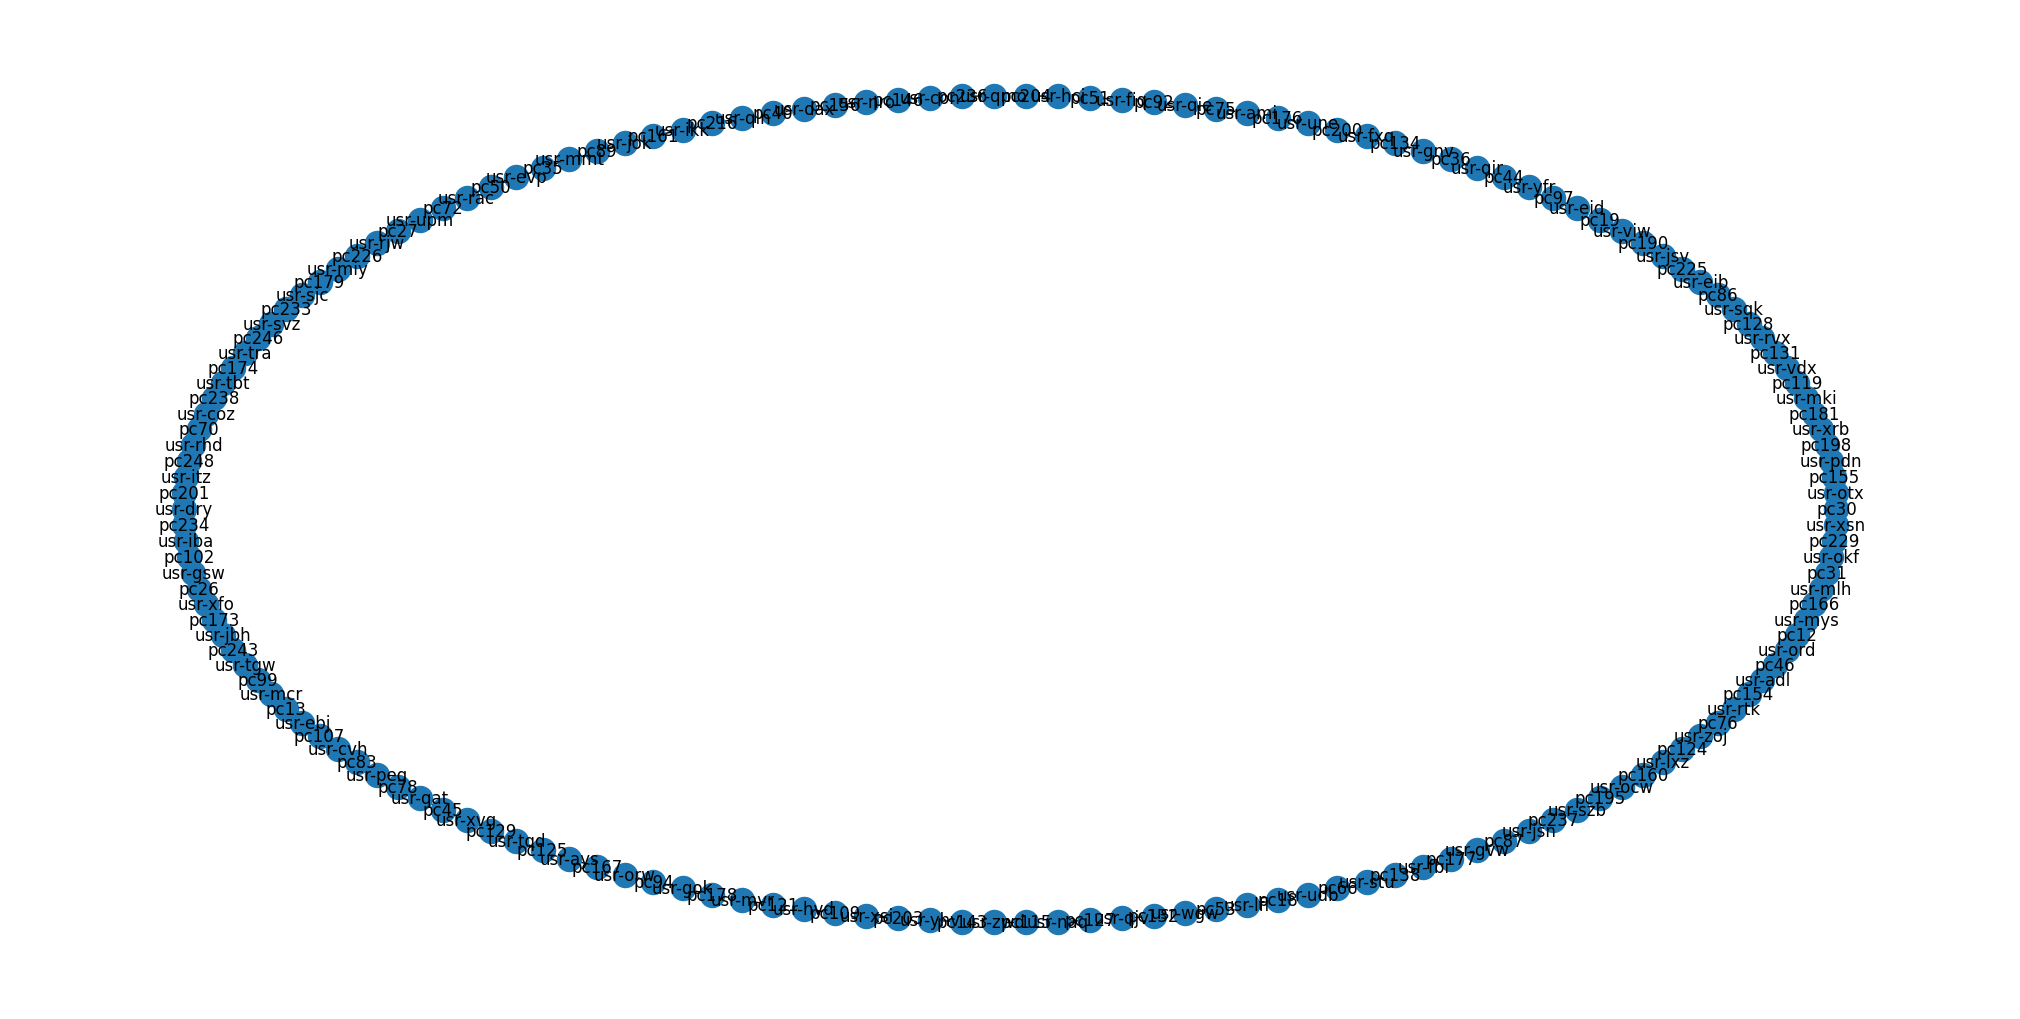

In [228]:
import networkx as nx
from matplotlib.pyplot import figure



G =nx.Graph()
G = nx.from_pandas_edgelist(usbSUS,'user','pc')

figure(figsize=(20, 10))
nx.draw_shell(G, with_labels=True)
G

In [229]:
leaderboard = {}
for x in G.nodes:
    leaderboard[x] = len(G[x])

s = pd.Series(leaderboard, name='connections')
network_data = s.to_frame().sort_values('connections', ascending=False)
network_data

,connections
usr-dry,1
pc204,1
pc97,1
usr-yfr,1
pc44,1
...,...
pc177,1
usr-gvw,1
pc87,1
usr-jsn,1


In [40]:
file = pd.DataFrame(file_data)
file['hours'] = file['datetime'].dt.hour
file

,datetime,user,filename,hours
0,2020-01-01 00:42:25.544227,usr-ipd,/policy,0
1,2020-01-01 00:50:48.627385,usr-hyo,/do_not_delete,0
2,2020-01-01 01:01:38.409035,usr-hyo,/newsletter,1
3,2020-01-01 01:14:49.310254,usr-hyo,/tech,1
4,2020-01-01 01:17:22.914953,usr-hyo,/newsletter,1
...,...,...,...,...
3799265,2020-11-30 23:40:54.695141,usr-lnn,/newsletter/general,23
3799266,2020-11-30 23:48:35.828385,usr-nic,/secret,23
3799267,2020-11-30 23:49:02.955959,usr-vul,/company_profile,23
3799268,2020-11-30 23:49:28.216624,usr-nic,/private/staffreview,23


In [170]:
dfEF = pd.merge(file,employee_data)
dfEF

,datetime,user,filename,hours,hour_categories,role,email,pc
0,2020-01-01 00:42:25.544227,usr-ipd,/policy,0,midnight,Security,usr-ipd@onlinebargains.com,pc230
1,2020-01-01 01:18:58.475142,usr-ipd,/secret,1,morning,Security,usr-ipd@onlinebargains.com,pc230
2,2020-01-01 01:38:50.760860,usr-ipd,/do_not_delete,1,morning,Security,usr-ipd@onlinebargains.com,pc230
3,2020-01-01 02:18:59.920793,usr-ipd,/misc,2,morning,Security,usr-ipd@onlinebargains.com,pc230
4,2020-01-01 04:14:09.646274,usr-ipd,/docs,4,morning,Security,usr-ipd@onlinebargains.com,pc230
...,...,...,...,...,...,...,...,...
3799265,2020-11-30 22:06:45.633534,usr-vcj,/tech,22,evening,Director,usr-vcj@onlinebargains.com,pc141
3799266,2020-11-30 22:12:39.260878,usr-vcj,/company_profile,22,evening,Director,usr-vcj@onlinebargains.com,pc141
3799267,2020-11-30 22:12:40.181453,usr-vcj,/docs,22,evening,Director,usr-vcj@onlinebargains.com,pc141
3799268,2020-11-30 22:19:08.096308,usr-vcj,/tech,22,evening,Director,usr-vcj@onlinebargains.com,pc141


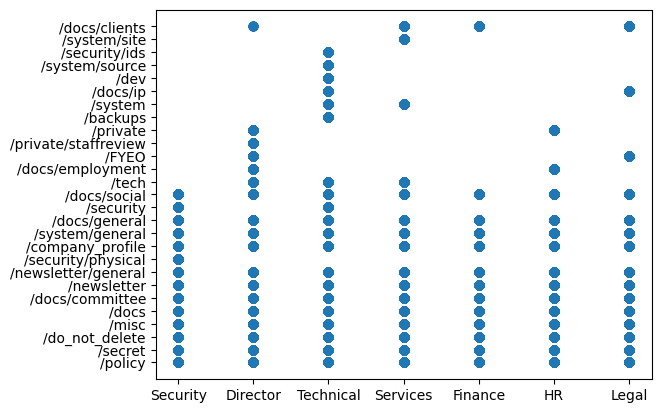

In [173]:
plt.scatter(dfEF['role'],dfEF['filename'])

In [41]:
#Files reached by the suspect
fileSUS= file.loc[(file['user']=='usr-rhd')]
file_sus=fileSUS['filename'].unique() 
len(file_sus)

18

In [42]:
#A director to compare with the suspect
fileDirector = file.loc[(file['user']=='usr-dmi')]
file_director=fileDirector['filename'].unique()
len(file_director)

17

In [43]:
#Another director to compare with the suspect
file2Director = file.loc[(file['user']=='usr-hxr')]
file_2director=file2Director['filename'].unique()
len(file_2director)

17

In [44]:
file_2director

array(['/do_not_delete', '/docs/employment', '/docs/committee', '/docs',
       '/policy', '/company_profile', '/tech', '/secret', '/FYEO',
       '/misc', '/private', '/docs/social', '/newsletter',
       '/docs/general', '/private/staffreview', '/system/general',
       '/newsletter/general'], dtype=object)

In [45]:
# the file "/docs/clients" does not appear in any other directors' reached files but the suspect.
file_sus

array(['/private', '/docs/general', '/private/staffreview',
       '/company_profile', '/misc', '/docs/social', '/docs/employment',
       '/newsletter', '/docs', '/docs/committee', '/newsletter/general',
       '/tech', '/policy', '/system/general', '/secret', '/do_not_delete',
       '/FYEO', '/docs/clients'], dtype=object)

In [46]:
dcFile=file.loc[file['filename']=='/docs/clients']
dcFile

,datetime,user,filename,hours
115,2020-01-01 04:46:15.298311,usr-hci,/docs/clients,4
358,2020-01-01 06:06:28.849977,usr-rjw,/docs/clients,6
380,2020-01-01 06:10:42.033664,usr-xrb,/docs/clients,6
386,2020-01-01 06:11:26.972366,usr-upm,/docs/clients,6
474,2020-01-01 06:28:54.786324,usr-vdx,/docs/clients,6
...,...,...,...,...
3798364,2020-11-30 18:26:00.923285,usr-rkl,/docs/clients,18
3798459,2020-11-30 18:41:54.788018,usr-qir,/docs/clients,18
3798570,2020-11-30 19:01:12.489525,usr-jok,/docs/clients,19
3798732,2020-11-30 19:35:28.756520,usr-yfr,/docs/clients,19


In [47]:
#as seen below the only director reached to the '/docs/clients' content is the suspect.
user_list=dcFile['user'].unique()

for i in range(0,len(user_list)):
    print(employee_data.loc[employee_data['user'] == user_list[i]])

        user      role                       email     pc
204  usr-hci  Services  usr-hci@onlinebargains.com  pc204
        user      role                       email     pc
226  usr-rjw  Services  usr-rjw@onlinebargains.com  pc226
        user      role                       email     pc
181  usr-xrb  Services  usr-xrb@onlinebargains.com  pc181
       user      role                       email    pc
27  usr-upm  Services  usr-upm@onlinebargains.com  pc27
        user      role                       email     pc
131  usr-vdx  Services  usr-vdx@onlinebargains.com  pc131
        user      role                       email     pc
198  usr-pdn  Services  usr-pdn@onlinebargains.com  pc198
        user      role                       email     pc
128  usr-rvx  Services  usr-rvx@onlinebargains.com  pc128
       user      role                       email    pc
30  usr-xsn  Services  usr-xsn@onlinebargains.com  pc30
        user      role                       email     pc
229  usr-okf  Services

In [175]:
dfEF.loc[(dfEF['user']=='usr-rhd')&(dfEF['filename']=='/docs/clients')]

,datetime,user,filename,hours,hour_categories,role,email,pc
1950960,2020-08-05 08:22:02.124616,usr-rhd,/docs/clients,8,morning,Director,usr-rhd@onlinebargains.com,pc152
1950967,2020-08-05 09:00:57.812958,usr-rhd,/docs/clients,9,morning,Director,usr-rhd@onlinebargains.com,pc152
1950972,2020-08-05 10:57:56.551124,usr-rhd,/docs/clients,10,morning,Director,usr-rhd@onlinebargains.com,pc152
1950973,2020-08-05 11:14:07.651841,usr-rhd,/docs/clients,11,morning,Director,usr-rhd@onlinebargains.com,pc152
1950974,2020-08-05 11:15:32.100920,usr-rhd,/docs/clients,11,morning,Director,usr-rhd@onlinebargains.com,pc152
1950975,2020-08-05 11:19:35.422989,usr-rhd,/docs/clients,11,morning,Director,usr-rhd@onlinebargains.com,pc152
1950979,2020-08-05 11:41:44.882480,usr-rhd,/docs/clients,11,morning,Director,usr-rhd@onlinebargains.com,pc152
1950988,2020-08-05 12:50:59.042643,usr-rhd,/docs/clients,12,morning,Director,usr-rhd@onlinebargains.com,pc152
1950989,2020-08-05 12:55:58.319592,usr-rhd,/docs/clients,12,morning,Director,usr-rhd@onlinebargains.com,pc152
1950990,2020-08-05 13:03:20.534977,usr-rhd,/docs/clients,13,afternoon,Director,usr-rhd@onlinebargains.com,pc152


In [49]:
email_data['hours'] = email_data['datetime'].dt.hour
email_data

,datetime,sender,recipient,hours
0,2020-01-01 00:25:57.087778,usr-hyo@onlinebargains.com,usr-utk@onlinebargains.com,0
1,2020-01-01 00:47:20.397203,usr-hhe@onlinebargains.com,usr-ipd@onlinebargains.com,0
2,2020-01-01 00:48:40.053151,usr-hhe@onlinebargains.com,usr-eid@onlinebargains.com,0
3,2020-01-01 00:49:16.631294,usr-ipd@onlinebargains.com,usr-yfr@onlinebargains.com,0
4,2020-01-01 00:53:43.526221,usr-hfz@onlinebargains.com,usr-gnv@onlinebargains.com,0
...,...,...,...,...
3795054,2020-11-30 23:29:32.371501,usr-lnn@onlinebargains.com,usr-dmi@onlinebargains.com,23
3795055,2020-11-30 23:31:01.419672,usr-alj@onlinebargains.com,usr-okf@onlinebargains.com,23
3795056,2020-11-30 23:34:34.291689,usr-fbi@onlinebargains.com,usr-gok@onlinebargains.com,23
3795057,2020-11-30 23:46:33.302502,usr-nic@onlinebargains.com,usr-gsw@onlinebargains.com,23


In [50]:
#checking if there is an email that is not ends with the company tag
diff = email_data.loc[email_data['recipient'].str.endswith('@onlinebargains.com')]
diff

,datetime,sender,recipient,hours
0,2020-01-01 00:25:57.087778,usr-hyo@onlinebargains.com,usr-utk@onlinebargains.com,0
1,2020-01-01 00:47:20.397203,usr-hhe@onlinebargains.com,usr-ipd@onlinebargains.com,0
2,2020-01-01 00:48:40.053151,usr-hhe@onlinebargains.com,usr-eid@onlinebargains.com,0
3,2020-01-01 00:49:16.631294,usr-ipd@onlinebargains.com,usr-yfr@onlinebargains.com,0
4,2020-01-01 00:53:43.526221,usr-hfz@onlinebargains.com,usr-gnv@onlinebargains.com,0
...,...,...,...,...
3795054,2020-11-30 23:29:32.371501,usr-lnn@onlinebargains.com,usr-dmi@onlinebargains.com,23
3795055,2020-11-30 23:31:01.419672,usr-alj@onlinebargains.com,usr-okf@onlinebargains.com,23
3795056,2020-11-30 23:34:34.291689,usr-fbi@onlinebargains.com,usr-gok@onlinebargains.com,23
3795057,2020-11-30 23:46:33.302502,usr-nic@onlinebargains.com,usr-gsw@onlinebargains.com,23


In [194]:
email_rhd = email_data[(email_data['sender']=='usr-rhd@onlinebargains.com')]
email_rhd

,datetime,sender,recipient,hours,hour_categories
1454,2020-01-01 08:33:57.699658,usr-rhd@onlinebargains.com,usr-ocw@onlinebargains.com,8,morning
1560,2020-01-01 08:44:46.452362,usr-rhd@onlinebargains.com,usr-xgk@onlinebargains.com,8,morning
1822,2020-01-01 09:08:20.292748,usr-rhd@onlinebargains.com,usr-ylf@onlinebargains.com,9,morning
2074,2020-01-01 09:28:49.979235,usr-rhd@onlinebargains.com,usr-nho@onlinebargains.com,9,morning
2973,2020-01-01 10:24:43.450697,usr-rhd@onlinebargains.com,usr-rjw@onlinebargains.com,10,morning
...,...,...,...,...,...
3795020,2020-11-30 22:43:12.886843,usr-rhd@onlinebargains.com,usr-pzz@onlinebargains.com,22,evening
3795024,2020-11-30 22:46:45.248826,usr-rhd@onlinebargains.com,usr-ryi@onlinebargains.com,22,evening
3795032,2020-11-30 22:51:07.948810,usr-rhd@onlinebargains.com,usr-vsl@onlinebargains.com,22,evening
3795035,2020-11-30 22:57:49.054229,usr-rhd@onlinebargains.com,usr-ndr@onlinebargains.com,22,evening


In [238]:
#hours the suspect emailed himself
email_rhd_self=email_rhd[(email_rhd['recipient']=='usr-rhd@onlinebargains.com')]
email_rhd_self['hours'].value_counts()

15    13
14    13
17     9
11     9
16     9
18     8
13     7
19     6
7      5
20     5
10     4
21     4
8      3
5      3
12     3
9      2
2      2
6      2
1      1
3      1
0      1
23     1
Name: hours, dtype: int64

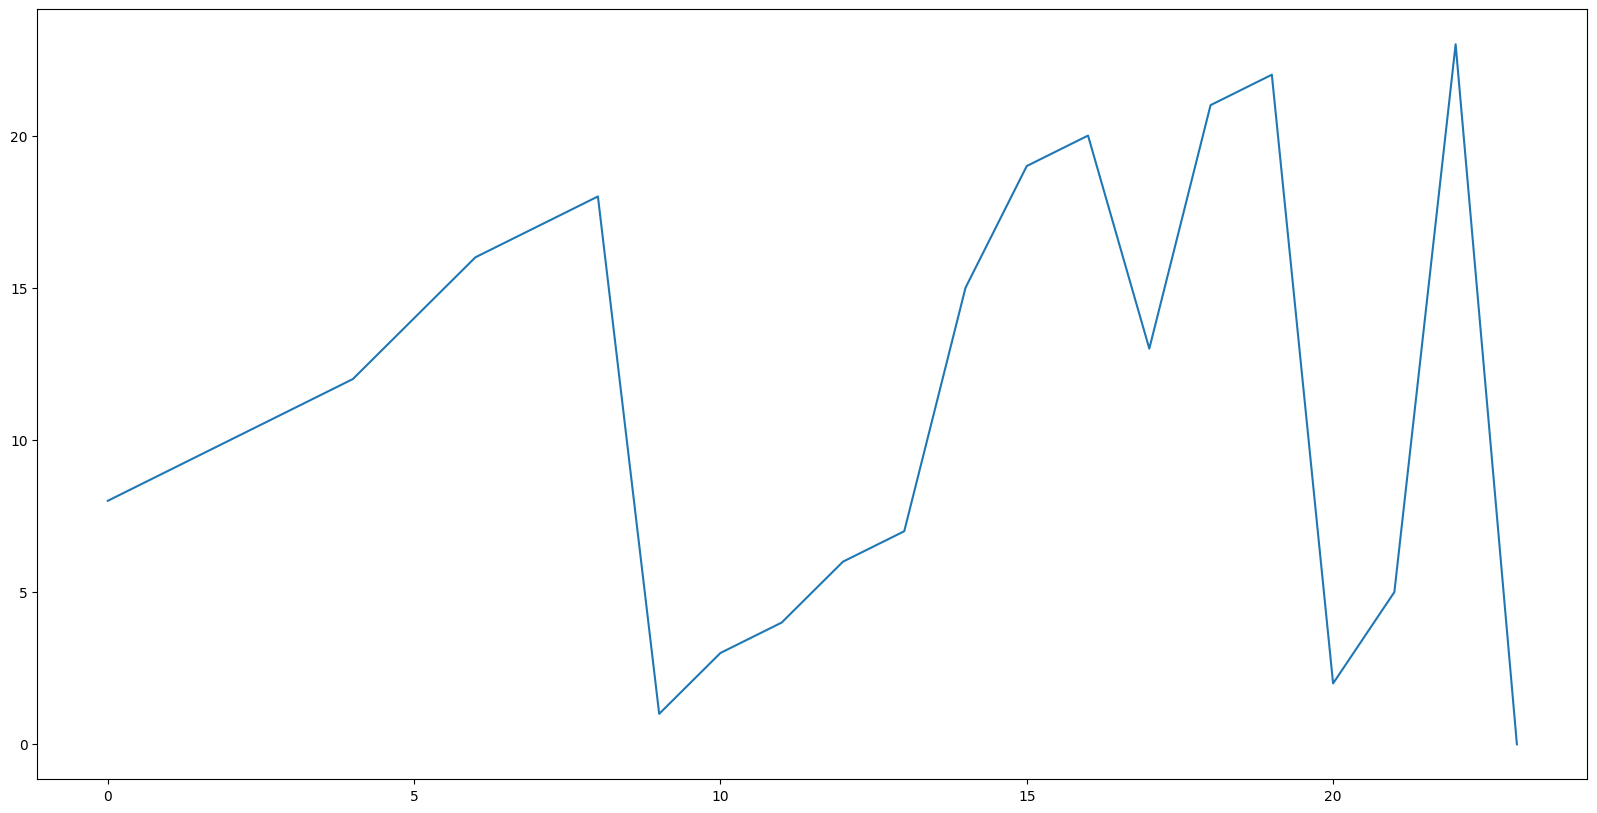

In [241]:
#visualising the hours suspect has an activity 
figure(figsize=(20,10))
plt.plot(email_rhd['hours'].unique())

In [230]:
import networkx as nx
from matplotlib.pyplot import figure


G =nx.Graph()
G = nx.from_pandas_edgelist(email_data,'sender','recipient')

leaderboard = {}
for x in G.nodes:
    leaderboard[x] = len(G[x])

s = pd.Series(leaderboard, name='connections')
network_email = s.to_frame().sort_values('connections', ascending=False)
network_email

,connections
usr-hyo@onlinebargains.com,249
usr-twi@onlinebargains.com,249
usr-nnk@onlinebargains.com,249
usr-zov@onlinebargains.com,249
usr-zth@onlinebargains.com,249
...,...
usr-iba@onlinebargains.com,56
usr-peg@onlinebargains.com,56
usr-mcr@onlinebargains.com,56
usr-tqd@onlinebargains.com,56


In [231]:
#to make sure the suspect has not sent any email to anyone out of the company
len(G['usr-rhd@onlinebargains.com'])

249

In [57]:
web_data

,datetime,user,website
0,2020-01-01 00:41:43.758417,usr-hfz,http://www.nifty.com
1,2020-01-01 01:21:44.679230,usr-wyj,http://www.posterous.com
2,2020-01-01 01:56:46.732056,usr-hvk,http://www.accuweather.com
3,2020-01-01 02:12:06.445196,usr-hfz,http://www.helpineedasecurity.net
4,2020-01-01 02:29:56.212579,usr-nrx,http://www.hc360.com
...,...,...,...
1376144,2020-11-30 22:52:41.821194,usr-ypo,http://www.prlog.org
1376145,2020-11-30 23:00:18.330519,usr-qat,http://www.sky.com
1376146,2020-11-30 23:18:50.514451,usr-ays,http://www.python.com
1376147,2020-11-30 23:19:03.111176,usr-nic,http://www.ebay.co.uk


In [60]:
web_data['hours'] = web_data['datetime'].dt.hour
web_data

,datetime,user,website,hours
0,2020-01-01 00:41:43.758417,usr-hfz,http://www.nifty.com,0
1,2020-01-01 01:21:44.679230,usr-wyj,http://www.posterous.com,1
2,2020-01-01 01:56:46.732056,usr-hvk,http://www.accuweather.com,1
3,2020-01-01 02:12:06.445196,usr-hfz,http://www.helpineedasecurity.net,2
4,2020-01-01 02:29:56.212579,usr-nrx,http://www.hc360.com,2
...,...,...,...,...
1376144,2020-11-30 22:52:41.821194,usr-ypo,http://www.prlog.org,22
1376145,2020-11-30 23:00:18.330519,usr-qat,http://www.sky.com,23
1376146,2020-11-30 23:18:50.514451,usr-ays,http://www.python.com,23
1376147,2020-11-30 23:19:03.111176,usr-nic,http://www.ebay.co.uk,23


In [232]:
dfEW = pd.merge(employee_data, web_data)
dfEW

,user,role,email,pc,datetime,website,hours,hour_categories
0,usr-uda,Security,usr-uda@onlinebargains.com,pc0,2020-01-01 17:54:08.385885,http://www.twitter.com,17,afternoon
1,usr-uda,Security,usr-uda@onlinebargains.com,pc0,2020-01-01 20:41:27.246604,http://www.theatlantic.com,20,evening
2,usr-uda,Security,usr-uda@onlinebargains.com,pc0,2020-01-01 20:50:58.945822,http://www.seesaa.net,20,evening
3,usr-uda,Security,usr-uda@onlinebargains.com,pc0,2020-01-02 01:33:22.086403,http://www.sky.com,1,morning
4,usr-uda,Security,usr-uda@onlinebargains.com,pc0,2020-01-02 03:54:16.384289,http://www.helpineedasecurity.net,3,morning
...,...,...,...,...,...,...,...,...
1376144,usr-eie,Finance,usr-eie@onlinebargains.com,pc248,2020-11-30 14:10:02.656403,http://www.hc360.com,14,afternoon
1376145,usr-eie,Finance,usr-eie@onlinebargains.com,pc248,2020-11-30 14:48:03.957719,http://www.prlog.org,14,afternoon
1376146,usr-eie,Finance,usr-eie@onlinebargains.com,pc248,2020-11-30 15:14:22.665886,http://www.humanresources.com,15,afternoon
1376147,usr-eie,Finance,usr-eie@onlinebargains.com,pc248,2020-11-30 16:09:58.631540,http://www.cateringcompany.com,16,afternoon


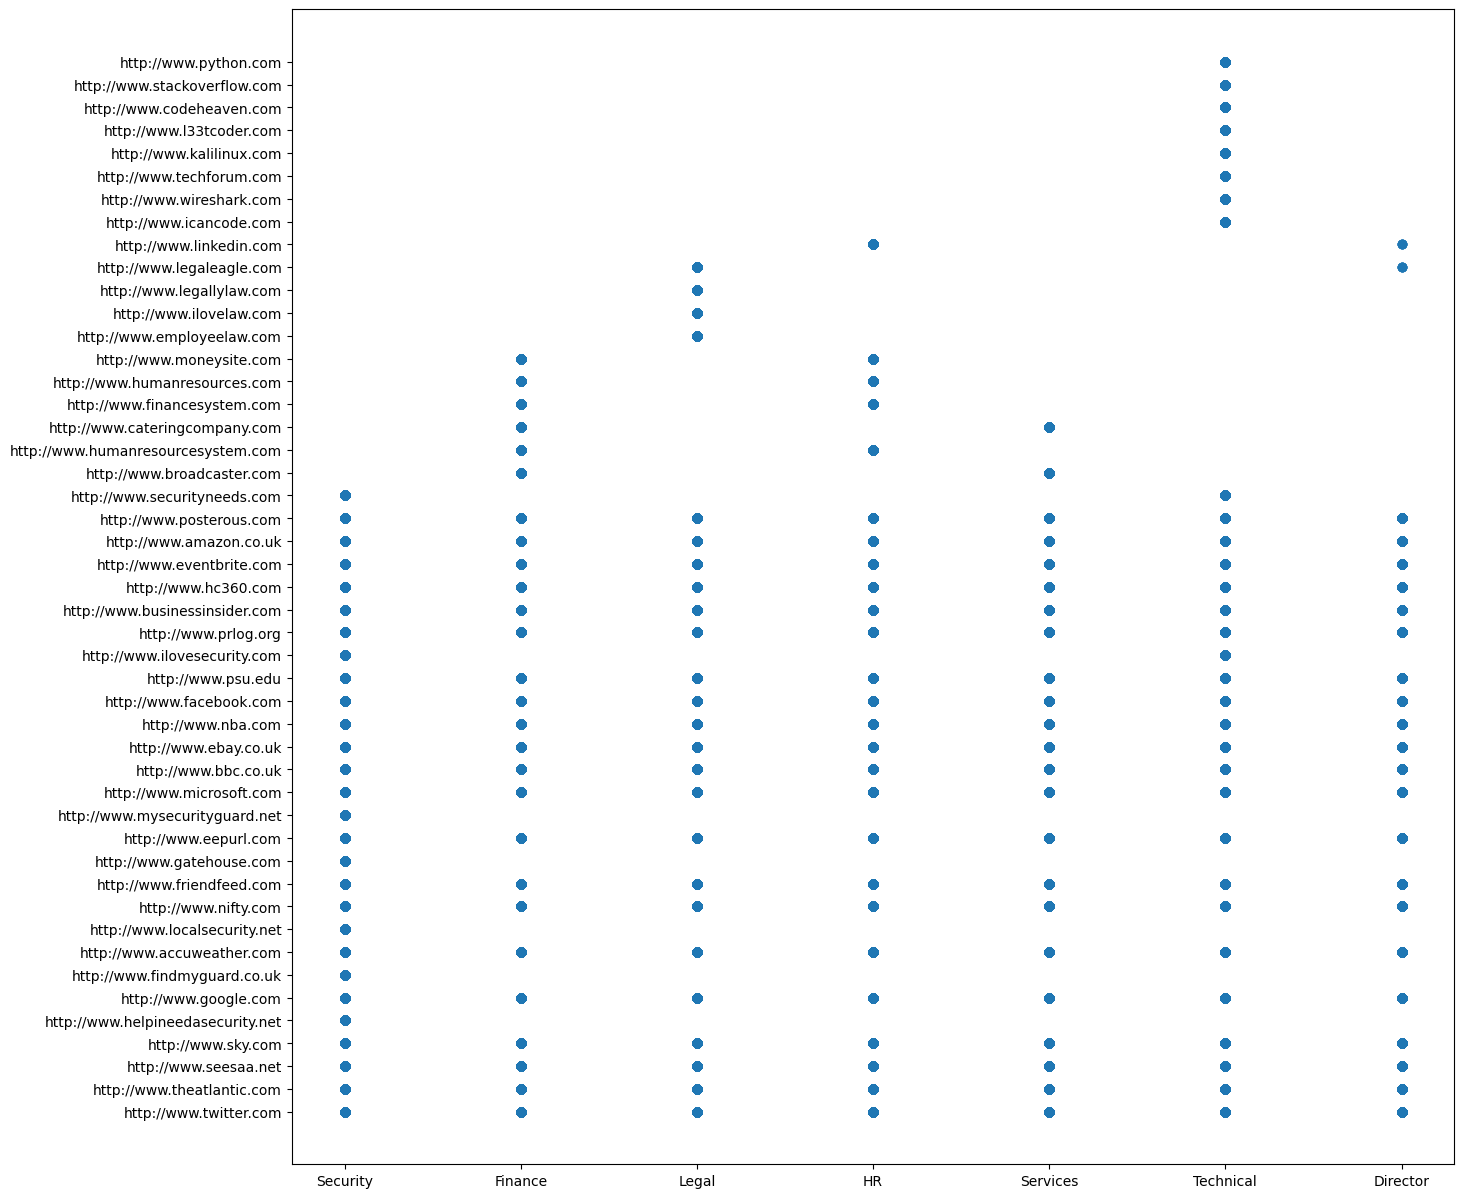

In [235]:
figure(figsize=(15,15))
plt.scatter(dfEW['role'],dfEW['website'])

In [263]:
dfEWSUS=dfEW[dfEW['user']=='usr-rhd']
dfEWSUS['website'].unique()

array(['http://www.nba.com', 'http://www.eepurl.com',
       'http://www.psu.edu', 'http://www.ebay.co.uk',
       'http://www.sky.com', 'http://www.businessinsider.com',
       'http://www.bbc.co.uk', 'http://www.posterous.com',
       'http://www.friendfeed.com', 'http://www.prlog.org',
       'http://www.nifty.com', 'http://www.theatlantic.com',
       'http://www.google.com', 'http://www.seesaa.net',
       'http://www.twitter.com', 'http://www.amazon.co.uk',
       'http://www.accuweather.com', 'http://www.microsoft.com',
       'http://www.facebook.com', 'http://www.hc360.com',
       'http://www.eventbrite.com', 'http://www.legaleagle.com',
       'http://www.linkedin.com'], dtype=object)

In [271]:
dfEWSUS[(dfEWSUS['website']=='http://www.legaleagle.com')]

,user,role,email,pc,datetime,website,hours,hour_categories
905852,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-08-10 04:06:46.274097,http://www.legaleagle.com,4,morning
905853,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-08-10 04:16:58.412490,http://www.legaleagle.com,4,morning
905854,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-08-10 05:05:36.455649,http://www.legaleagle.com,5,morning
905856,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-08-10 06:49:05.336062,http://www.legaleagle.com,6,morning
905859,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-08-10 10:30:59.392632,http://www.legaleagle.com,10,morning


In [277]:
dfEWSUS[(dfEWSUS['website']=='http://www.eepurl.com')&(dfEWSUS['hours']>=0)&(dfEWSUS['hours']<=8)]

,user,role,email,pc,datetime,website,hours,hour_categories
905239,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-01-17 06:10:15.665231,http://www.eepurl.com,6,morning
905264,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-01-25 05:02:18.807591,http://www.eepurl.com,5,morning
905409,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-03-15 06:43:14.671706,http://www.eepurl.com,6,morning
905723,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-06-28 08:29:42.598416,http://www.eepurl.com,8,morning
905773,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-07-14 08:04:17.677582,http://www.eepurl.com,8,morning
905837,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-08-05 08:43:53.779101,http://www.eepurl.com,8,morning
905926,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-08-30 04:33:03.644740,http://www.eepurl.com,4,morning
905938,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-09-04 05:48:19.900836,http://www.eepurl.com,5,morning
906011,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-09-27 07:12:56.733020,http://www.eepurl.com,7,morning
906098,usr-rhd,Director,usr-rhd@onlinebargains.com,pc152,2020-10-25 04:49:12.764348,http://www.eepurl.com,4,morning


# Conclusion - Summary of Findings

In [ ]:
#During the course of the investigation, it was discovered that a suspect, 'usr-rhd', had taken an USB action on a computer that did not belong to 
# them. This prompted a closer examination of various dataframes in order to gain a more detailed understanding of the suspect's actions and identify 
# any additional anomalies.

#Through an analysis of the 'login_data' dataframe, it was found that the suspect had logged into the system at times when they were not scheduled to 
# be present. Further examination of the 'usb_data' dataframe revealed that the computer in question belonged to 'usr-eie' from the finance department 
# and that the incident in question occurred between 8 and 9 pm on 07-08-2020 on the computer 'pc248', providing more context for the situation.

#Additionally, the 'file_data' dataframe was analyzed and it was determined that the suspect had accessed a file, '/docs/clients', multiple times 
# without the proper permissions as a director. Analysis of the 'email_data' dataframe revealed that the suspect had been sending emails to themselves, 
# which could indicate that files were being moved or copied through email. 

#Furthermore, the websites that the suspect had accessed were also examined, with particular attention paid to the sites 'eepURL' and 'legaleagle'. 
# The website 'eepURL' was found to be an URL shortener that had been used for criminal purposes in the past, while 'legaleagle' was a website for 
# a law office owned by an attorney named Richard P. Reichstein, which could be useful in trial and advisory. This leads to a deduction that the
# suspect is aware of the investigation process and want to be preapared in case of any legal process.

#Based on the findings from the various dataframes and the actions of the user 'usr-rhd', it is concluded that there were suspicious activities 
#with relevant evidence to support the conclusion.
